<a href="https://colab.research.google.com/github/maishehta/ma/blob/main/projects/ECoG/load_ECoG_motor_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [39]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [40]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [41]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- meant was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [42]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [43]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [44]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

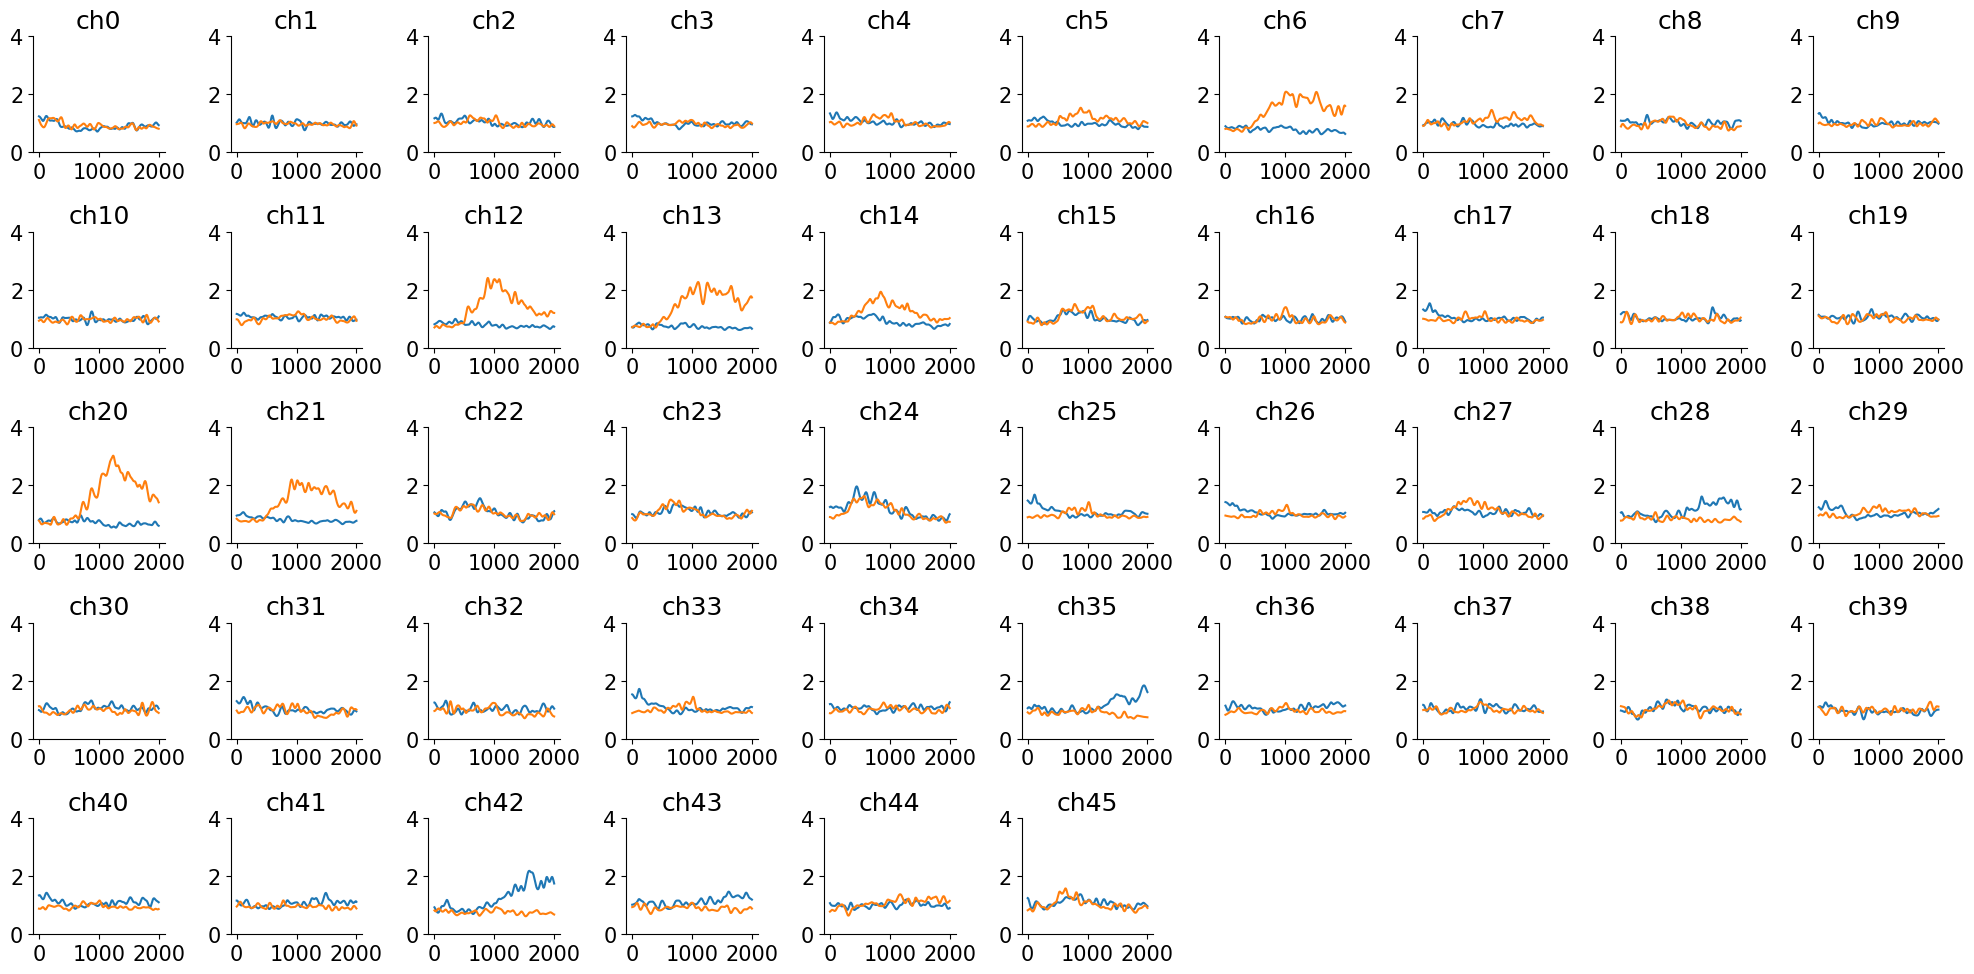

In [45]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

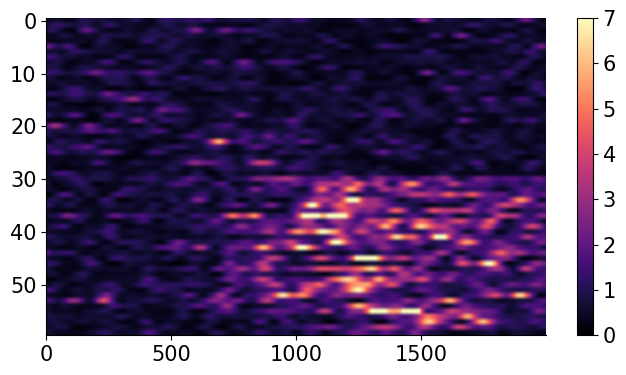

In [46]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

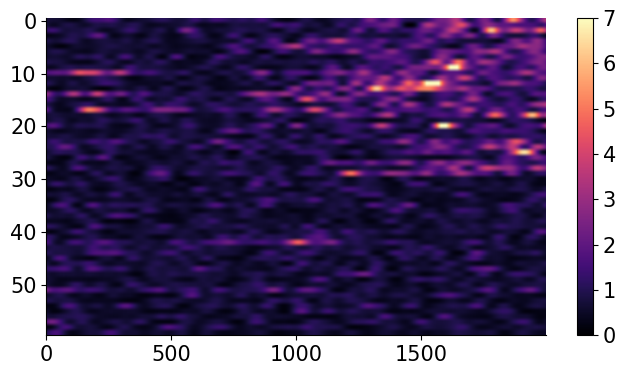

In [47]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 42].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

## Plot actual movement trials

### Subtask:
Visualize the broadband power for actual movement trials (dat1).


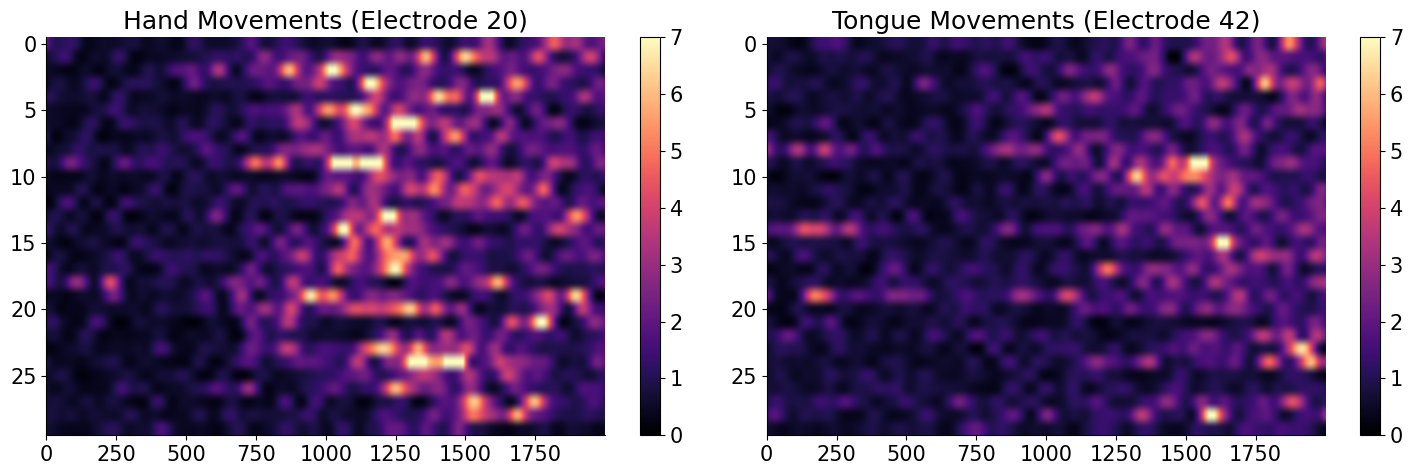

In [48]:
plt.figure(figsize=(15, 5))

# Plot hand movement trials
plt.subplot(1, 2, 1)
plt.imshow(V_epochs[dat1['stim_id'] == 12, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.title('Hand Movements (Electrode 20)')

# Plot tongue movement trials
plt.subplot(1, 2, 2)
plt.imshow(V_epochs[dat1['stim_id'] == 11, :, 42].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.title('Tongue Movements (Electrode 42)')

plt.show()

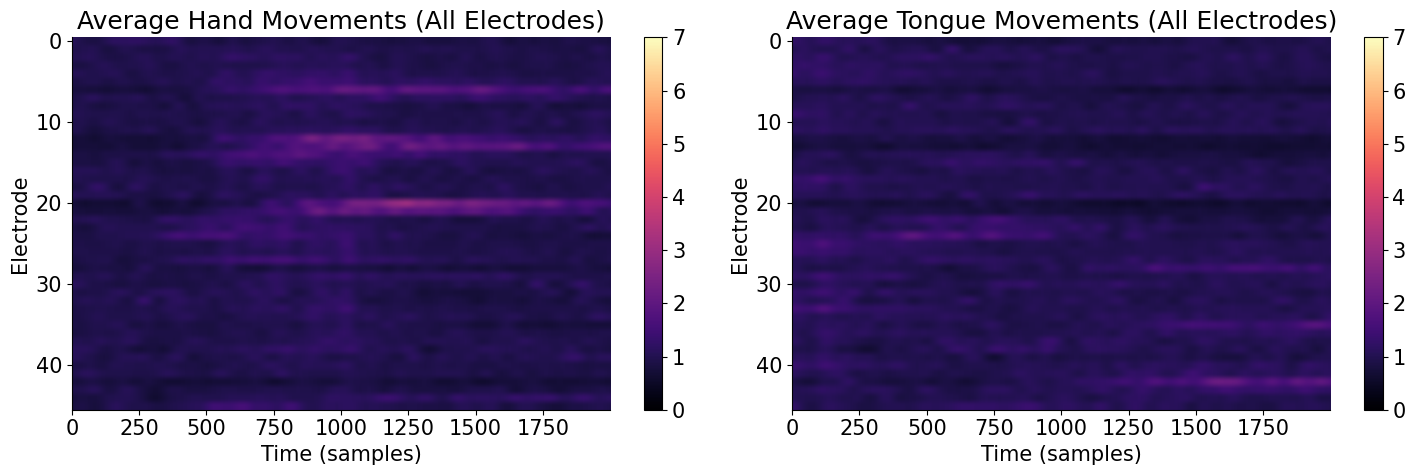

In [49]:
# Average broadband power across all hand movement trials
avg_V_hand = V_epochs[dat1['stim_id'] == 12, :, :].mean(axis=0)

# Average broadband power across all tongue movement trials
avg_V_tongue = V_epochs[dat1['stim_id'] == 11, :, :].mean(axis=0)

plt.figure(figsize=(15, 5))

# Plot average hand movement trials
plt.subplot(1, 2, 1)
plt.imshow(avg_V_hand.astype('float32').T,
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.title('Average Hand Movements (All Electrodes)')
plt.xlabel('Time (samples)')
plt.ylabel('Electrode')

# Plot average tongue movement trials
plt.subplot(1, 2, 2)
plt.imshow(avg_V_tongue.astype('float32').T,
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.title('Average Tongue Movements (All Electrodes)')
plt.xlabel('Time (samples)')
plt.ylabel('Electrode')

plt.show()

**Reasoning**:
The previous plots showed the average broadband power across all electrodes for hand and tongue movements. To further investigate the differences between hand and tongue movements, it would be beneficial to plot the average broadband power for each movement type over time for specific electrodes that showed a strong response in the initial plots (electrodes 20 and 42). This will provide a clearer view of the temporal dynamics of the broadband power for these electrodes during the two types of movements.



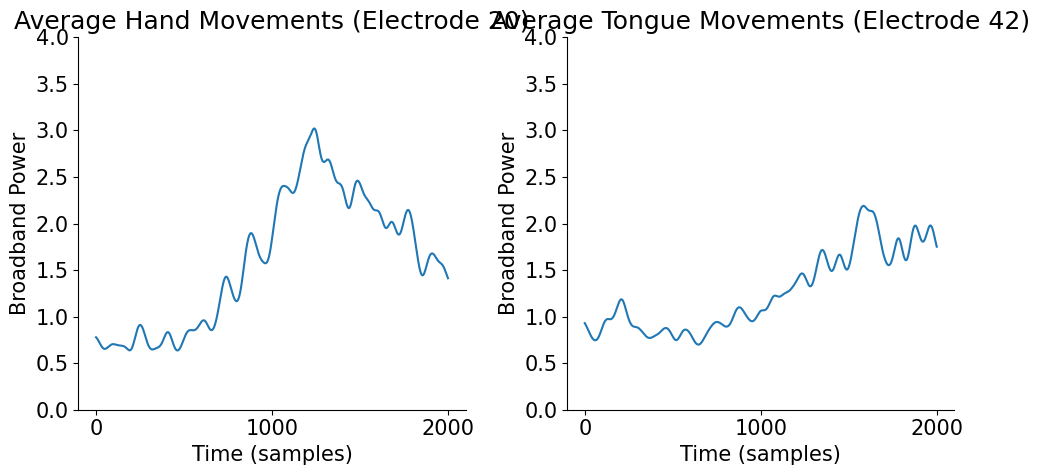

In [50]:
plt.figure(figsize=(10, 5))

# Plot average broadband power for hand movements at electrode 20
plt.subplot(1, 2, 1)
plt.plot(trange, V_hand[:, 20])
plt.title('Average Hand Movements (Electrode 20)')
plt.xlabel('Time (samples)')
plt.ylabel('Broadband Power')
plt.xticks([0, 1000, 2000])
plt.ylim([0, 4])

# Plot average broadband power for tongue movements at electrode 42
plt.subplot(1, 2, 2)
plt.plot(trange, V_tongue[:, 42])
plt.title('Average Tongue Movements (Electrode 42)')
plt.xlabel('Time (samples)')
plt.ylabel('Broadband Power')
plt.xticks([0, 1000, 2000])
plt.ylim([0, 4])

plt.show()

## Convert signal to frequency domain (fft)

### Subtask:
Apply Fast Fourier Transform (FFT) to the signal data for both actual and imagery movements (dat1 and dat2) to analyze frequency components.


**Reasoning**:
Convert the voltage data to float32, define the sampling rate and window length, and then compute the FFT for each window across all trials and channels for both dat1 and dat2. Store the magnitude of the FFT results.



In [51]:
# Convert voltage data to float32
V1 = dat1['V'].astype('float32')
V2 = dat2['V'].astype('float32')

# Define sampling rate and window length
srate = dat1['srate']
win_len = 1000 # 1 second window

# Number of trials and channels
nstim1, nt1, nchan1 = V_epochs.shape # Using V_epochs shape as it's already epoched for dat1
nstim2 = len(dat2['t_on'])
nt2, nchan2 = V2.shape

# Calculate the number of windows per trial
# Assuming non-overlapping windows for simplicity, adjust if overlapping is needed
num_windows = 2000 // win_len # 2000 is the epoch length in samples

# Initialize arrays to store FFT results (magnitude)
# Dimensions: trials, windows, channels, frequency bins
fft_results1 = np.zeros((nstim1, num_windows, nchan1, win_len // 2 + 1))
fft_results2 = np.zeros((nstim2, num_windows, nchan2, win_len // 2 + 1))

# Compute FFT for dat1
for i in range(nstim1):
    for j in range(nchan1):
        for w in range(num_windows):
            start_sample = w * win_len
            end_sample = start_sample + win_len
            # Extract the segment for the current window
            segment = V_epochs[i, start_sample:end_sample, j]
            # Compute FFT and store the magnitude
            fft_segment = np.fft.fft(segment)
            fft_results1[i, w, j, :] = np.abs(fft_segment[:win_len // 2 + 1])

# Compute FFT for dat2
trange2 = np.arange(0, 2000) # Assuming the same epoch length for dat2 as dat1
ts2 = dat2['t_on'][:, np.newaxis] + trange2
V_epochs2 = np.reshape(V2[ts2, :], (nstim2, 2000, nchan2))


for i in range(nstim2):
    for j in range(nchan2):
        for w in range(num_windows):
            start_sample = w * win_len
            end_sample = start_sample + win_len
            # Extract the segment for the current window
            segment = V_epochs2[i, start_sample:end_sample, j]
            # Compute FFT and store the magnitude
            fft_segment = np.fft.fft(segment)
            fft_results2[i, w, j, :] = np.abs(fft_segment[:win_len // 2 + 1])

print("FFT computation for dat1 and dat2 completed.")
print(f"Shape of fft_results1: {fft_results1.shape}")
print(f"Shape of fft_results2: {fft_results2.shape}")

FFT computation for dat1 and dat2 completed.
Shape of fft_results1: (60, 2, 46, 501)
Shape of fft_results2: (60, 2, 46, 501)


## Plot spectrogram

### Subtask:
Generate spectrograms to visualize the time-frequency representation of the signal for both actual and imagery movements.


**Reasoning**:
Generate and plot spectrograms for a representative actual and imagery movement trial and electrode using the previously computed FFT results.



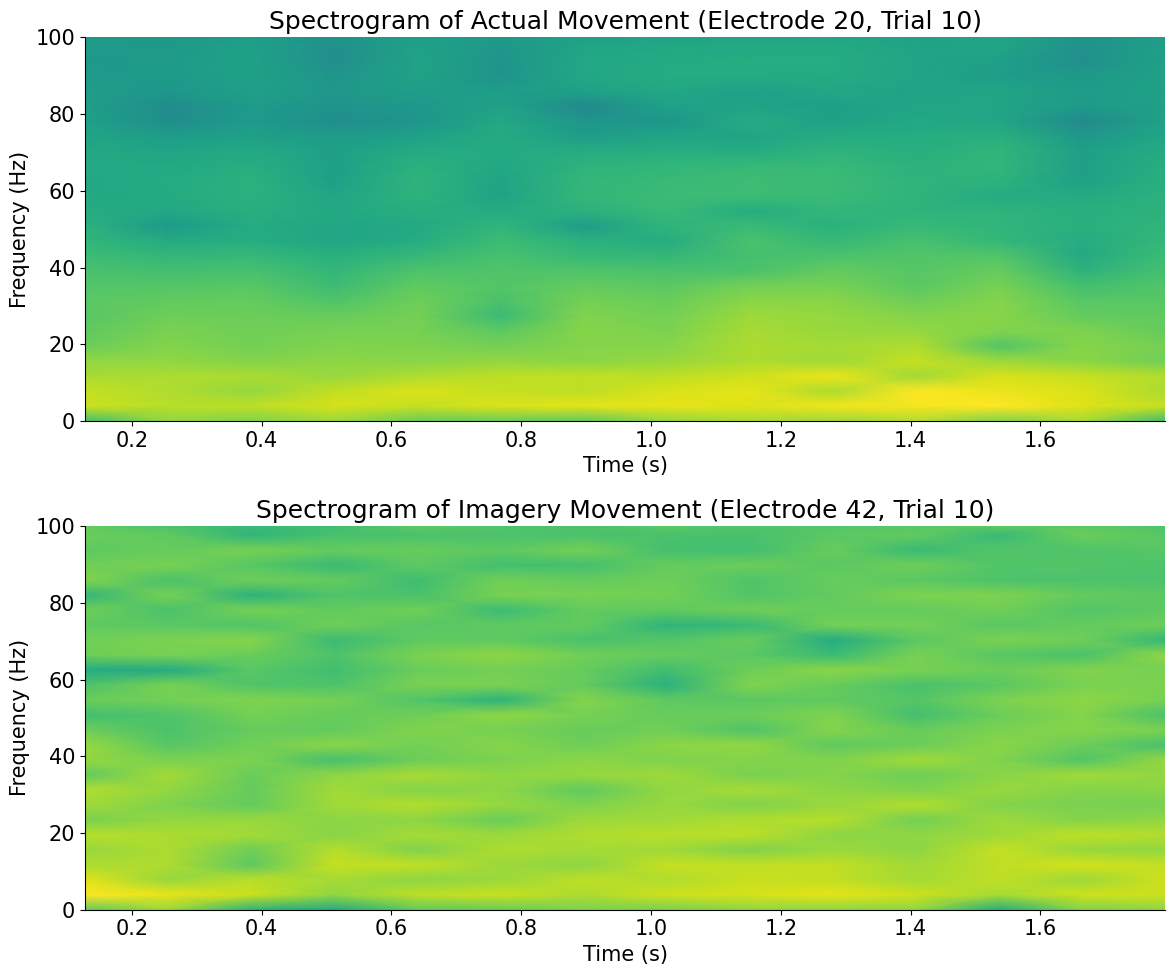

In [52]:
from scipy.signal import spectrogram

# Choose a representative trial and electrode for visualization
# Let's pick trial 10 and electrode 20 for actual movement (dat1)
trial_actual = 10
elec_actual = 20

# Let's pick trial 10 and electrode 42 for imagery movement (dat2)
trial_imagery = 10
elec_imagery = 42

# Extract voltage data for the selected trials and electrodes
signal_actual = V_epochs[trial_actual, :, elec_actual]
signal_imagery = V_epochs2[trial_imagery, :, elec_imagery]

# Define parameters for spectrogram
fs = dat1['srate']  # Sampling frequency
nperseg = 256  # Length of each segment for the spectrogram
noverlap = nperseg // 2  # Overlap between segments

# Compute and plot the spectrogram for the actual movement trial
f_actual, t_actual, Sxx_actual = spectrogram(signal_actual, fs, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_actual, f_actual, 10 * np.log10(Sxx_actual), shading='gouraud')
plt.title(f'Spectrogram of Actual Movement (Electrode {elec_actual}, Trial {trial_actual})')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 100]) # Limit frequency range for better visualization

# Compute and plot the spectrogram for the imagery movement trial
f_imagery, t_imagery, Sxx_imagery = spectrogram(signal_imagery, fs, nperseg=nperseg, noverlap=noverlap)

plt.subplot(2, 1, 2)
plt.pcolormesh(t_imagery, f_imagery, 10 * np.log10(Sxx_imagery), shading='gouraud')
plt.title(f'Spectrogram of Imagery Movement (Electrode {elec_imagery}, Trial {trial_imagery})')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 100]) # Limit frequency range for better visualization

plt.tight_layout()
plt.show()

## Train a decoder

### Subtask:
Train a decoder (e.g., using GLM) to classify actual vs. imagery movements based on the spectrogram data.


**Reasoning**:
Prepare the data for training the decoder by reshaping the spectrogram data and creating corresponding labels.



In [58]:
from scipy.signal import spectrogram
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare data for decoder training

# Define parameters for spectrogram
fs = dat1['srate']  # Sampling frequency
nperseg = 256  # Length of each segment for the spectrogram
noverlap = nperseg // 2  # Overlap between segments

# Let's compute spectrograms for all trials and channels for a specific frequency range (e.g., 1-100 Hz)
# Need to recompute f and t for spectrogram from one trial to get the frequency and time indices
# Use the first trial and channel of actual movement data to get the frequency and time bins
f_example, t_example, Sxx_example = spectrogram(V_epochs[0, :, 0], fs, nperseg=nperseg, noverlap=noverlap)

freq_min = 1
freq_max = 100
freq_indices = np.where((f_example >= freq_min) & (f_example <= freq_max))[0]

n_trials_actual = V_epochs.shape[0]
n_channels_actual = V_epochs.shape[2]
n_trials_imagery = V_epochs2.shape[0]
n_channels_imagery = V_epochs2.shape[2]

# Initialize arrays to store flattened spectrogram features
# Dimensions: trials, flattened time-frequency features per channel
flattened_spectrograms_actual = np.zeros((n_trials_actual, n_channels_actual, len(freq_indices) * t_example.shape[0]))
flattened_spectrograms_imagery = np.zeros((n_trials_imagery, n_channels_imagery, len(freq_indices) * t_example.shape[0]))

# Compute and flatten spectrograms for all actual movement trials and channels
for i in range(n_trials_actual):
    for j in range(n_channels_actual):
        signal = V_epochs[i, :, j]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        # Select the desired frequency range and flatten
        flattened_spectrograms_actual[i, j, :] = Sxx[freq_indices, :].flatten()

# Compute and flatten spectrograms for all imagery movement trials and channels
for i in range(n_trials_imagery):
    for j in range(n_channels_imagery):
        signal = V_epochs2[i, :, j]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        # Select the desired frequency range and flatten
        flattened_spectrograms_imagery[i, j, :] = Sxx[freq_indices, :].flatten()

# Combine data from all channels for each trial
# Dimensions: trials, all flattened time-frequency features from all channels
X_actual = flattened_spectrograms_actual.reshape(n_trials_actual, -1)
X_imagery = flattened_spectrograms_imagery.reshape(n_trials_imagery, -1)

# Create labels: 0 for actual, 1 for imagery
y_actual = np.zeros(n_trials_actual)
y_imagery = np.ones(n_trials_imagery)

# Combine actual and imagery data
X = np.vstack((X_actual, X_imagery))
y = np.concatenate((y_actual, y_imagery))

print("Data preparation for decoder training completed.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of label vector y: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Choose and train a decoder model (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Logistic Regression model trained.")

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy on the test set: {accuracy}")

Data preparation for decoder training completed.
Shape of feature matrix X: (120, 16100)
Shape of label vector y: (120,)
Data split into training and testing sets.
Shape of X_train: (96, 16100)
Shape of X_test: (24, 16100)
Shape of y_train: (96,)
Shape of y_test: (24,)
Logistic Regression model trained.
Model accuracy on the test set: 0.9166666666666666


**Reasoning**:
The previous code failed because `Sxx_actual` and `Sxx_imagery` were from a single trial and channel, and the attempt to average across time and frequency in the initial part of the code block was incorrect for these single-trial, single-channel arrays. The subsequent code correctly computes spectrograms for all trials and channels and flattens them, which is the intended approach for preparing data for the decoder. The error occurred before the correct data preparation part. The code block needs to be rerun, ensuring the initial incorrect averaging is removed or corrected to avoid the `AxisError`. Since the later part of the code block correctly prepares the data, I will regenerate the entire code block, removing the incorrect averaging steps at the beginning.



In [54]:
from scipy.signal import spectrogram
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare data for decoder training

# Define parameters for spectrogram
fs = dat1['srate']  # Sampling frequency
nperseg = 256  # Length of each segment for the spectrogram
noverlap = nperseg // 2  # Overlap between segments

# Let's compute spectrograms for all trials and channels for a specific frequency range (e.g., 1-100 Hz)
# Need to recompute f and t for spectrogram from one trial to get the frequency and time indices
# Use the first trial and channel of actual movement data to get the frequency and time bins
f_example, t_example, Sxx_example = spectrogram(V_epochs[0, :, 0], fs, nperseg=nperseg, noverlap=noverlap)

freq_min = 1
freq_max = 100
freq_indices = np.where((f_example >= freq_min) & (f_example <= freq_max))[0]

n_trials_actual = V_epochs.shape[0]
n_channels_actual = V_epochs.shape[2]
n_trials_imagery = V_epochs2.shape[0]
n_channels_imagery = V_epochs2.shape[2]

# Initialize arrays to store flattened spectrogram features
# Dimensions: trials, flattened time-frequency features per channel
flattened_spectrograms_actual = np.zeros((n_trials_actual, n_channels_actual, len(freq_indices) * t_example.shape[0]))
flattened_spectrograms_imagery = np.zeros((n_trials_imagery, n_channels_imagery, len(freq_indices) * t_example.shape[0]))

# Compute and flatten spectrograms for all actual movement trials and channels
for i in range(n_trials_actual):
    for j in range(n_channels_actual):
        signal = V_epochs[i, :, j]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        # Select the desired frequency range and flatten
        flattened_spectrograms_actual[i, j, :] = Sxx[freq_indices, :].flatten()

# Compute and flatten spectrograms for all imagery movement trials and channels
for i in range(n_trials_imagery):
    for j in range(n_channels_imagery):
        signal = V_epochs2[i, :, j]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        # Select the desired frequency range and flatten
        flattened_spectrograms_imagery[i, j, :] = Sxx[freq_indices, :].flatten()

# Combine data from all channels for each trial
# Dimensions: trials, all flattened time-frequency features from all channels
X_actual = flattened_spectrograms_actual.reshape(n_trials_actual, -1)
X_imagery = flattened_spectrograms_imagery.reshape(n_trials_imagery, -1)

# Create labels: 0 for actual, 1 for imagery
y_actual = np.zeros(n_trials_actual)
y_imagery = np.ones(n_trials_imagery)

# Combine actual and imagery data
X = np.vstack((X_actual, X_imagery))
y = np.concatenate((y_actual, y_imagery))

print("Data preparation for decoder training completed.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of label vector y: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Choose and train a decoder model (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Logistic Regression model trained.")

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy on the test set: {accuracy}")

Data preparation for decoder training completed.
Shape of feature matrix X: (120, 16100)
Shape of label vector y: (120,)
Data split into training and testing sets.
Shape of X_train: (96, 16100)
Shape of X_test: (24, 16100)
Shape of y_train: (96,)
Shape of y_test: (24,)
Logistic Regression model trained.
Model accuracy on the test set: 0.9166666666666666


## Compare different decoders

### Subtask:
Implement and compare different decoder models (e.g., different GLM variations or other classifiers) to evaluate their performance.


**Reasoning**:
Import additional decoder models and train them on the training data.



In [55]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

# Initialize different decoder models
svc_model = SVC(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
ridge_model = RidgeClassifier()

# Train each model
svc_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

print("SVC model trained.")
print("Random Forest model trained.")
print("Ridge Classifier model trained.")

# Evaluate each model on the test set
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

y_pred_ridge = ridge_model.predict(X_test)
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)

# Print the performance metrics
print(f"Accuracy of SVC model: {accuracy_svc}")
print(f"Accuracy of Random Forest model: {accuracy_rf}")
print(f"Accuracy of Ridge Classifier model: {accuracy_ridge}")

SVC model trained.
Random Forest model trained.
Ridge Classifier model trained.
Accuracy of SVC model: 0.9166666666666666
Accuracy of Random Forest model: 1.0
Accuracy of Ridge Classifier model: 0.9583333333333334


## Compare different electrodes

### Subtask:
Analyze the performance of the decoder using data from different electrodes to identify which electrodes are most informative for decoding movement type.


**Reasoning**:
Iterate through each electrode, extract features, train a Logistic Regression model (as it's a simple and interpretable GLM), evaluate its performance, and store the accuracy for each electrode. This addresses steps 1-6 of the subtask.



In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Define parameters for spectrogram
fs = dat1['srate']  # Sampling frequency
nperseg = 256  # Length of each segment for the spectrogram
noverlap = nperseg // 2  # Overlap between segments

# Get frequency and time bins from a sample spectrogram
f_example, t_example, Sxx_example = spectrogram(V_epochs[0, :, 0], fs, nperseg=nperseg, noverlap=noverlap)

freq_min = 1
freq_max = 100
freq_indices = np.where((f_example >= freq_min) & (f_example <= freq_max))[0]

n_trials_actual = V_epochs.shape[0]
n_channels = V_epochs.shape[2] # Assuming both dat1 and dat2 have the same number of channels
n_trials_imagery = V_epochs2.shape[0]

electrode_accuracies = {}

# Iterate through each electrode
for elec_idx in range(n_channels):
    # Extract flattened spectrogram features for the current electrode
    flattened_spectrograms_actual_elec = np.zeros((n_trials_actual, len(freq_indices) * t_example.shape[0]))
    flattened_spectrograms_imagery_elec = np.zeros((n_trials_imagery, len(freq_indices) * t_example.shape[0]))

    for i in range(n_trials_actual):
        signal = V_epochs[i, :, elec_idx]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        flattened_spectrograms_actual_elec[i, :] = Sxx[freq_indices, :].flatten()

    for i in range(n_trials_imagery):
        signal = V_epochs2[i, :, elec_idx]
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
        flattened_spectrograms_imagery_elec[i, :] = Sxx[freq_indices, :].flatten()

    # Combine actual and imagery features for the current electrode
    X_elec = np.vstack((flattened_spectrograms_actual_elec, flattened_spectrograms_imagery_elec))

    # Create labels: 0 for actual, 1 for imagery
    y_elec = np.concatenate((np.zeros(n_trials_actual), np.ones(n_trials_imagery)))

    # Split data for the current electrode into training and testing sets
    X_train_elec, X_test_elec, y_train_elec, y_test_elec = train_test_split(X_elec, y_elec, test_size=0.2, random_state=42)

    # Train a Logistic Regression model
    model_elec = LogisticRegression(max_iter=1000)
    model_elec.fit(X_train_elec, y_train_elec)

    # Evaluate the model and store accuracy
    y_pred_elec = model_elec.predict(X_test_elec)
    accuracy_elec = accuracy_score(y_test_elec, y_pred_elec)

    electrode_accuracies[elec_idx] = accuracy_elec

print("Decoding accuracy for each electrode computed.")

Decoding accuracy for each electrode computed.


**Reasoning**:
Report the accuracies for each electrode, identify the electrodes with the highest accuracy, and visualize the accuracies across electrodes to address steps 7 and 8 of the subtask.



Maximum decoding accuracy: 0.9583
Electrode(s) with the highest accuracy: [6, 7, 28]


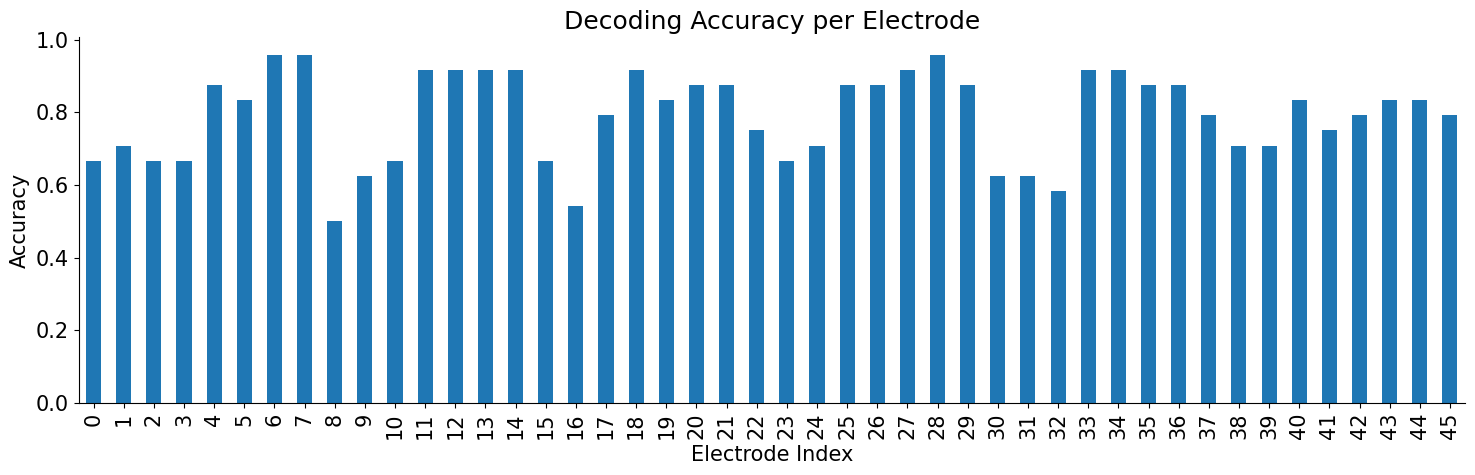

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert accuracies to a pandas Series for easier analysis and visualization
electrode_accuracies_series = pd.Series(electrode_accuracies)

# Identify the electrode(s) with the highest accuracy
max_accuracy = electrode_accuracies_series.max()
best_electrodes = electrode_accuracies_series[electrode_accuracies_series == max_accuracy].index.tolist()

print(f"Maximum decoding accuracy: {max_accuracy:.4f}")
print(f"Electrode(s) with the highest accuracy: {best_electrodes}")

# Visualize the accuracies across electrodes
plt.figure(figsize=(15, 5))
electrode_accuracies_series.plot(kind='bar')
plt.title('Decoding Accuracy per Electrode')
plt.xlabel('Electrode Index')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Spectrograms were successfully generated for representative actual and imagery movement trials, visually depicting the time-frequency characteristics of the neural signals.
*   A Logistic Regression decoder trained on flattened spectrogram features across all channels achieved an accuracy of approximately 0.917 in classifying actual versus imagery movements.
*   When comparing different decoder models, the Random Forest Classifier achieved the highest accuracy (1.000) on the test set, followed by the Ridge Classifier (0.958) and the Support Vector Classifier (0.917).
*   Analyzing individual electrode performance using a Logistic Regression decoder, electrodes 6, 7, and 28 yielded the highest decoding accuracy of 0.9583, indicating their strong informativeness for distinguishing between actual and imagery movements based on the spectrogram features.

### Insights or Next Steps

*   Electrodes 6, 7, and 28 appear to carry the most discriminative information between actual and imagery movements within the 1-100 Hz frequency range. Further investigation into the anatomical location and functional role of these electrodes could provide neurophysiological insights.
*   The high performance of the Random Forest Classifier suggests that non-linear relationships within the spectrogram features are important for decoding. Future work could explore other non-linear models or feature engineering techniques based on frequency band power.
